# Part 2 : Reinforcement Learning

## Task 2 :
Several examples can be given for this.
- A common example are the autonomous cars. State space here is all the indicators and sensors equipped in a car. This can include location info (GPS), indicators like speed, direction, road conditions like presence of pedestrians (these can be inferred from vision or through LIDAR/RADAR). The action space would involve all the controls the car has in play, like brakes, steering etc. This can be both continuous or discrete. Reward function depends on the needs, for instance performance, or respecitng the traffic laws etc. Penalties can be applied for not adhering to the requirements.
 
- Example from previous work : Method for exploring malaria intervention actions using AI agents, thereby assisting policy makers in making informed decisions regarding malaria control with limited resources. [link](https://arxiv.org/abs/1712.00428). This is performed on OpenMalaria simulator. Here, the problem is framed as a multi-armed bandit, and so there is no state transition involved in the simulations. The 'state' is essentially the initial simulation parameters and the simulated policy for a 5-year intervention period. The actions involve determining the coverage levels of ITNs and IRS within the target population. The reward for each policy is defined through a cost-effectiveness analysis based on the stochastic outputs of the OpenMalaria simulation.

- When a chain/sequence of decision making is involved in any application, it can likely be frames as MPD problem. A common scenario is rules of a game can be treated as MDP. Example : [My patent](https://patents.google.com/patent/US11275899B2/en)

## Task 3 :
One unique area where RL was employed (beyong playing games) was [discovering novel, efficient, and provably correct algorithms for fundamental tasks such as matrix multiplication.](https://deepmind.google/discover/blog/discovering-novel-algorithms-with-alphatensor/) AlphaTensor, employs a reinforcement learning framework with Monte Carlo Tree Search (MCTS) to automate the discovery of efficient matrix multiplication algorithms. 
- **State Space**: The state of the game is represented by a three-dimensional tensor that captures the difference between the current algorithm's output and the expected result of matrix multiplication. This tensor changes as the agent explores different algorithmic instructions, aiming to zero out its entries, which would imply a correct and potentially more efficient matrix multiplication algorithm.
- **Action Space**: The action space consists of permissible algorithmic instructions that modify the state tensor towards the goal. Due to the large size of the action space, actions are sampled.
- The agent has no knowledge of matrix multiplication algorithms and gradually learns by playing games against itself. Synthetic demonstrations, or artificially created examples of tensor decompositions, are used to train the network.
- In essence,  the game state after step t is described by a tensor T_t, which is initially set to the target tensor to be decomposed. In each step t of the game, the player selects a triplet (u(t), v(t), w(t)), and the tensor T_t is updated by subtracting the resulting rank-one tensor. The goal of the player is to reach the zero tensor by applying the smallest number of moves. When the player reaches the zero tensor, the sequence of selected factors satisfies the multiplication of components which guarantees the correctness of the resulting matrix multiplication algorithm. For every step taken, we provide a reward of −1 to encourage finding the shortest path to the zero tensor.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

## Task 4
We will first implement the game. The state space here is basically 9 boxes to fill. Important operations here is basically filling a box (letter) and determining if after filling, the game is won or not. This is basically a check of if rows or columns or diagonals are same.

In [ ]:
class TicTacToe: # we begin by implementing the game first
    def __init__(self):
        self.board = [' '] * 9 # state space 3x3 board.
        self.current_winner = None # game winner

    def empty_space(self):
        return [i for i, empty in enumerate(self.board) if empty == ' '] # autocomplete helped here a bit

    def fill_letter(self, position, letter):
        if self.board[position] == ' ':
            self.board[position] = letter
            if self.winner(position, letter):
                self.current_winner = letter
            return True # space was filled
        return False # space wasn't filled

    def winner(self, position, letter): # we now check if after the move a player has won or not.
        # if row is same
        row_ind = position // 3
        row = self.board[row_ind*3 : (row_ind + 1) * 3]
        if all([spot == letter for spot in row]):
            return True

        # if column is same
        col_ind = position % 3
        column = [self.board[col_ind+i*3] for i in range(3)]
        if all([spot == letter for spot in column]):
            return True

        # if diagonal is same
        if position % 2 == 0:
            diagonal1 = [self.board[i] for i in [0, 4, 8]]
            if all([spot == letter for spot in diagonal1]):
                return True
            diagonal2 = [self.board[i] for i in [2, 4, 6]]
            if all([spot == letter for spot in diagonal2]):
                return True
        return False

    def print_board(self): # print board to show in the end a few runs
        for row in [self.board[i*3:(i+1)*3] for i in range(3)]:
            print('| ' + ' | '.join(row) + ' |')

Now we'll implement the Q-Learning agent. Typically, this would involve getting the state and its q-value if there. The agent then takes an action which is basically sampling based on q-table (exploit or explore), and then finally updating the q-values based on Bellman's equation.

In [ ]:
#now we will implement the Q-Learnign Agent
class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.6, epsilon=0.1):
        self.q_table = {}  # q-table
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon  # exploration rate

    def get_state(self, game): # board is the state space
        return str(game.board)

    def get_q_value(self, state, action):  # q-value for a given state and action
        return self.q_table.get((state, action), 0)  # default q value is 0

    def choose_action(self, state, available_actions):  # action based on the current state (explore or exploit)
        if random.random() < self.epsilon:  # explore with a small probability
            return random.choice(available_actions)
        else:  # exploit
            q_values = [self.get_q_value(state, action) for action in available_actions]
            max_q_value = max(q_values) #highest q-value action
            actions_with_max_q = [action for action, q in zip(available_actions, q_values) if q == max_q_value] # if multiple actions have same q-value, randomly choose between those
            return random.choice(actions_with_max_q)

    def update_q_value(self, state, action, reward, next_state, available_actions):  # update q-table
        old_q_value = self.get_q_value(state, action)
        future_rewards = [self.get_q_value(next_state, a) for a in available_actions]
        max_future_reward = max(future_rewards, default=0)
        new_q_value = old_q_value + self.alpha * (reward + self.gamma * max_future_reward - old_q_value) # bellman's equation
        self.q_table[(state, action)] = new_q_value

Couple of things we'll observe for checking the performance of agent.
1. No. of wins/losses/draws over time.
2. Episode Length. Typically as the model learns more and more, episode length becomes smaller.

In [ ]:
def train_agent(episodes=1000, report_every=100):
    player = QLearningAgent() #agent to be trained
    opponent = 'O'
    results = {'Win': 0, 'Loss': 0, 'Draw': 0} #we basically see the win percent of the game
    performance_history = []
    episode_lengths = []  # length of each episode

    for episode in range(1, episodes + 1):
        game = TicTacToe()
        state = player.get_state(game)
        done = False
        steps = 0  # Track the number of steps in the current episode

        while not done:
            action = player.choose_action(state, game.empty_space())
            game.fill_letter(action, 'X')  # Player's move
            steps += 1

            new_state = player.get_state(game)
            if game.current_winner == 'X':  # Player wins
                player.update_q_value(state, action, 1, new_state, [])
                results['Win'] += 1
                break
            elif not game.empty_space():  # Draw
                player.update_q_value(state, action, 0, new_state, [])
                results['Draw'] += 1
                break
            else:  # Game continues
                opponent_move = random.choice(game.empty_space())
                game.fill_letter(opponent_move, opponent)
                steps += 1
                new_state = player.get_state(game)
                if game.current_winner == opponent:  # Opponent wins
                    player.update_q_value(state, action, -1, new_state, [])
                    results['Loss'] += 1
                    done = True
                elif not game.empty_space():  # Draw
                    player.update_q_value(state, action, 0, new_state, [])
                    results['Draw'] += 1
                    done = True
                else:
                    player.update_q_value(state, action, 0, new_state, game.empty_space())
                    state = new_state  # Update state for the next iteration

        # Record performance

        if episode % report_every == 0:
            performance_history.append({k: v / report_every for k, v in results.items()})
            episode_lengths.append(steps)
            results = {'Win': 0, 'Loss': 0, 'Draw': 0}  # Reset counters

    return player, performance_history, episode_lengths

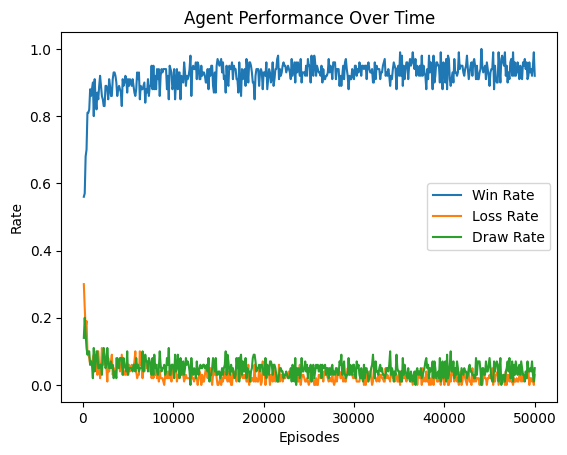

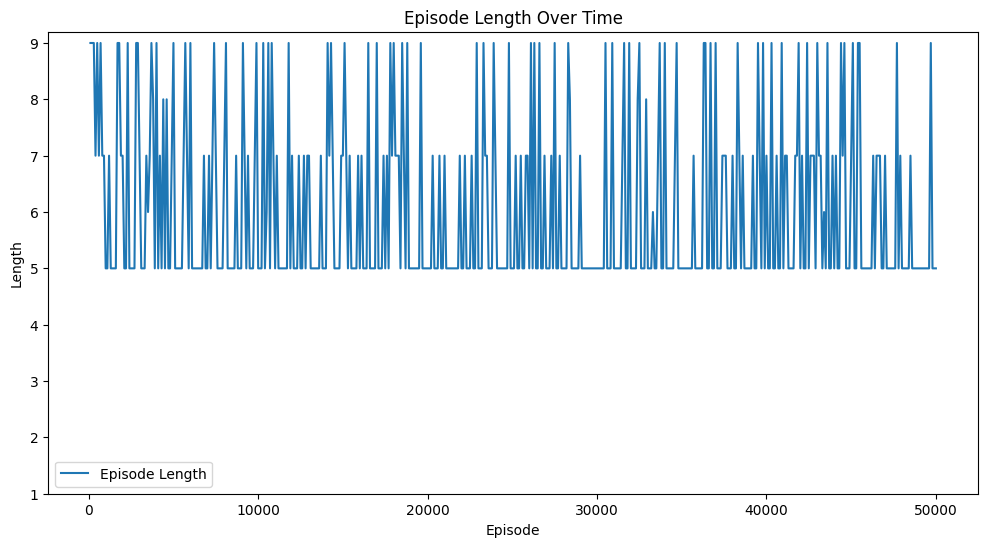

In [ ]:
num_episodes = 50000
report_every = 100
player, performance_history, episode_lengths = train_agent(num_episodes, report_every)

# Plotting
episodes = list(range(100, num_episodes+1, 100))
win_rates = [h['Win'] for h in performance_history]
loss_rates = [h['Loss'] for h in performance_history]
draw_rates = [h['Draw'] for h in performance_history]

plt.plot(episodes, win_rates, label='Win Rate')
plt.plot(episodes, loss_rates, label='Loss Rate')
plt.plot(episodes, draw_rates, label='Draw Rate')
plt.xlabel('Episodes')
plt.ylabel('Rate')
plt.title('Agent Performance Over Time')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(episodes,episode_lengths, label='Episode Length')
plt.xlabel('Episode')
plt.ylabel('Length')
plt.title('Episode Length Over Time')
plt.ylim(bottom=1)
plt.legend()
plt.show()

We'll also show a few example gameplay episodes. 

In [ ]:
def play_game(agent, game, verbose=True):
    current_player = 'X'  # 'X' is written by Q-learning agent
    while True:
        state = agent.get_state(game)
        if current_player == 'X':
            action = agent.choose_action(state, game.empty_space())
            game.fill_letter(action, current_player)
            if verbose:
                print(f"Player {current_player} moves to {action}")
                game.print_board()
                print("\n")
            if game.current_winner or not game.empty_space():
                if verbose:
                    if game.current_winner:
                        print(f"Player {current_player} wins!")
                    else:
                        print("It's a draw!")
                return game.current_winner
        else:
            # opponent's move. makes a random move. We can also make the opponent an agent as well. 
            action = random.choice(game.empty_space())
            game.fill_letter(action, current_player)
            if verbose:
                print(f"Player {current_player} moves to {action}")
                game.print_board()
                print("\n")
            if game.current_winner or not game.empty_space():
                if verbose:
                    if game.current_winner:
                        print(f"Player {current_player} wins!")
                    else:
                        print("It's a draw!")
                return game.current_winner

        current_player = 'O' if current_player == 'X' else 'X'  # switch turns

In [ ]:
for episode in range(4):  # 4 episodes
    print(f"Episode {episode + 1}:")
    game = TicTacToe()
    agent = QLearningAgent()
    play_game(agent, game)
    print("================================\n")

Episode 1:
Player X moves to 0
| X |   |   |
|   |   |   |
|   |   |   |


Player O moves to 1
| X | O |   |
|   |   |   |
|   |   |   |


Player X moves to 2
| X | O | X |
|   |   |   |
|   |   |   |


Player O moves to 6
| X | O | X |
|   |   |   |
| O |   |   |


Player X moves to 4
| X | O | X |
|   | X |   |
| O |   |   |


Player O moves to 3
| X | O | X |
| O | X |   |
| O |   |   |


Player X moves to 5
| X | O | X |
| O | X | X |
| O |   |   |


Player O moves to 7
| X | O | X |
| O | X | X |
| O | O |   |


Player X moves to 8
| X | O | X |
| O | X | X |
| O | O | X |


Player X wins!

Episode 2:
Player X moves to 1
|   | X |   |
|   |   |   |
|   |   |   |


Player O moves to 8
|   | X |   |
|   |   |   |
|   |   | O |


Player X moves to 6
|   | X |   |
|   |   |   |
| X |   | O |


Player O moves to 0
| O | X |   |
|   |   |   |
| X |   | O |


Player X moves to 5
| O | X |   |
|   |   | X |
| X |   | O |


Player O moves to 4
| O | X |   |
|   | O | X |
| X |   | O |


Pl